### data 불러오기

In [96]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
%matplotlib inline
import gensim.models.keyedvectors as word2vec
import gc
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer 
from nltk.corpus import stopwords

In [72]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### cleaning

In [73]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    #comment=comment.lower()
    #remove \n
    comment=re.sub("\\n"," ",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    #words = tokenizer.fit_on_texts(comment)
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [74]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [75]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [76]:
tokenizer=TweetTokenizer()
lem = WordNetLemmatizer()
eng_stopwords = set(stopwords.words("english"))

In [77]:
train['comment_text']=train['comment_text'].apply(lambda x:clean(x))
test['comment_text']=test['comment_text'].apply(lambda x:clean(x))

### Modeling

In [78]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [79]:
from keras.preprocessing.text import Tokenizer

In [80]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [81]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [117]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
        if(typeToLoad=="glove"):
            EMBEDDING_FILE='glove.6B.200d.txt'
            embed_size = 200
        elif(typeToLoad=="word2vec"):
            word2vecDict = word2vec.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
            embed_size = 300
        elif(typeToLoad=="fasttext"):
            EMBEDDING_FILE='wiki-news-300d-1M-subword.vec'
            embed_size = 300

        if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
            embeddings_index = dict()
            #Transfer the embedding weights into a dictionary by iterating through every line of the file.
            f = open(EMBEDDING_FILE)
            for line in f:
                #split up line into an indexed array
                values = line.split()
                #first index is word
                word = values[0]
                #store the rest of the values in the array as a new array
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs #50 dimensions
            f.close()
            print('Loaded %s word vectors.' % len(embeddings_index))
        else:
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        
        all_embs = np.stack(list(embeddings_index.values()))
        
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        
        nb_words = len(tokenizer.word_index)
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix

#### GLOVE

In [62]:
embedding_matrix = loadEmbeddingMatrix('glove')

Loaded 400000 word vectors.
total embedded: 90324 common words


In [63]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

In [64]:
#keras start
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [65]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [66]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 200, 200)          37456000  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200, 120)          125280    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 120)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0   

In [67]:
batch_size = 128
epochs = 10
hist_glove = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 260s 2ms/step - loss: 0.1092 - accuracy: 0.9680 - val_loss: 0.0736 - val_accuracy: 0.9762
Epoch 2/10
127656/127656 [==============================] - 262s 2ms/step - loss: 0.0693 - accuracy: 0.9775 - val_loss: 0.0617 - val_accuracy: 0.9793
Epoch 3/10
127656/127656 [==============================] - 261s 2ms/step - loss: 0.0609 - accuracy: 0.9794 - val_loss: 0.0571 - val_accuracy: 0.9803
Epoch 4/10
127656/127656 [==============================] - 260s 2ms/step - loss: 0.0559 - accuracy: 0.9805 - val_loss: 0.0547 - val_accuracy: 0.9809
Epoch 5/10
127656/127656 [==============================] - 262s 2ms/step - loss: 0.0529 - accuracy: 0.9813 - val_loss: 0.0540 - val_accuracy: 0.9813
Epoch 6/10
127656/127656 [==============================] - 261s 2ms/step - loss: 0.0505 - accuracy: 0.9818 - val_loss: 0.0524 - val_accuracy: 0.9816
Epoch 7/10
127656/127656 [=======================

In [68]:
#loadEmbeddingMatrix('word2vec')

#### Googlenews

In [84]:
embedding_matrix = loadEmbeddingMatrix('word2vec')

/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Loaded 3000000 word vectors.
total embedded: 60479 common words


In [85]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

In [86]:
#keras start
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [87]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [88]:
batch_size = 128
epochs = 10
hist_google = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 267s 2ms/step - loss: 0.1113 - accuracy: 0.9684 - val_loss: 0.0738 - val_accuracy: 0.9764
Epoch 2/10
127656/127656 [==============================] - 266s 2ms/step - loss: 0.0680 - accuracy: 0.9783 - val_loss: 0.0621 - val_accuracy: 0.9795
Epoch 3/10
127656/127656 [==============================] - 267s 2ms/step - loss: 0.0599 - accuracy: 0.9800 - val_loss: 0.0576 - val_accuracy: 0.9803
Epoch 4/10
127656/127656 [==============================] - 266s 2ms/step - loss: 0.0552 - accuracy: 0.9808 - val_loss: 0.0548 - val_accuracy: 0.9809
Epoch 5/10
127656/127656 [==============================] - 266s 2ms/step - loss: 0.0519 - accuracy: 0.9815 - val_loss: 0.0528 - val_accuracy: 0.9813
Epoch 6/10
127656/127656 [==============================] - 266s 2ms/step - loss: 0.0497 - accuracy: 0.9821 - val_loss: 0.0520 - val_accuracy: 0.9817
Epoch 7/10
127656/127656 [=======================

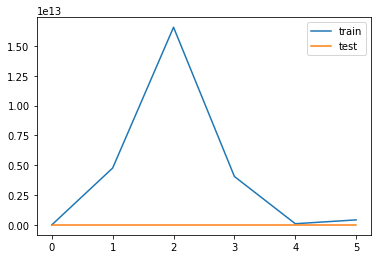

In [89]:
# plot history
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()                                       
plt.show()                       

#### fasttext

In [120]:
f = codecs.open('wiki.simple.vec', encoding='utf-8')
for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [127]:
MAX_NB_WORDS = 187280
embed_dim = 300

In [128]:
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 130848


In [129]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

In [130]:
#keras start
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [131]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [132]:
batch_size = 128
epochs = 10
hist_fasttext = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 269s 2ms/step - loss: 0.0836 - accuracy: 0.9736 - val_loss: 0.0567 - val_accuracy: 0.9798
Epoch 2/10
127656/127656 [==============================] - 267s 2ms/step - loss: 0.0557 - accuracy: 0.9803 - val_loss: 0.0519 - val_accuracy: 0.9810
Epoch 3/10
127656/127656 [==============================] - 267s 2ms/step - loss: 0.0516 - accuracy: 0.9814 - val_loss: 0.0497 - val_accuracy: 0.9817
Epoch 4/10
127656/127656 [==============================] - 267s 2ms/step - loss: 0.0490 - accuracy: 0.9820 - val_loss: 0.0487 - val_accuracy: 0.9821
Epoch 5/10
127656/127656 [==============================] - 267s 2ms/step - loss: 0.0468 - accuracy: 0.9826 - val_loss: 0.0484 - val_accuracy: 0.9824
Epoch 6/10
127656/127656 [==============================] - 267s 2ms/step - loss: 0.0452 - accuracy: 0.9831 - val_loss: 0.0476 - val_accuracy: 0.9825
Epoch 7/10
127656/127656 [=======================

#### baseline

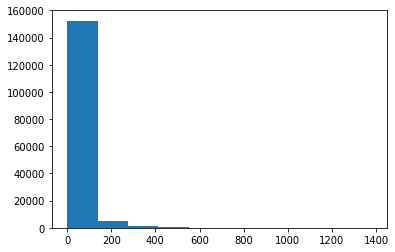

In [133]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords)
plt.show()

In [134]:
inp = Input(shape=(maxlen, ))

In [135]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU,Conv1D,MaxPooling1D

In [136]:
embed_size = 240
x = Embedding(len(tokenizer.word_index)+1, embed_size)(inp)
#x = Conv1D(filters=100,kernel_size=4,padding='same', activation='relu')(x)
#x=MaxPooling1D(pool_size=4)(x)
x = Bidirectional(GRU(60, return_sequences=True,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)


In [137]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                 metrics=['accuracy'])
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 200, 240)          44947440  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 200, 120)          108360    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 120)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                6050      
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 306 

In [144]:
batch_size = 128
epochs = 10
#uncomment below to train in your local machine
hist_base = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 439s 3ms/step - loss: 1217139783719.5542 - accuracy: 0.9821 - val_loss: 0.0642 - val_accuracy: 0.9783
Epoch 2/10
127656/127656 [==============================] - 439s 3ms/step - loss: 36195868348.3507 - accuracy: 0.9825 - val_loss: 0.0630 - val_accuracy: 0.9786
Epoch 3/10
127656/127656 [==============================] - 439s 3ms/step - loss: 31138998745.9343 - accuracy: 0.9833 - val_loss: 0.0631 - val_accuracy: 0.9786
Epoch 4/10
127656/127656 [==============================] - 440s 3ms/step - loss: 249967366737.6761 - accuracy: 0.9834 - val_loss: 0.0637 - val_accuracy: 0.9784
Epoch 5/10
127656/127656 [==============================] - 417s 3ms/step - loss: 134080285.0916 - accuracy: 0.9838 - val_loss: 0.0643 - val_accuracy: 0.9784
Epoch 6/10
127656/127656 [==============================] - 389s 3ms/step - loss: 167254465336.5110 - accuracy: 0.9812 - val_loss: 0.0696 - val_accu

#### visualization

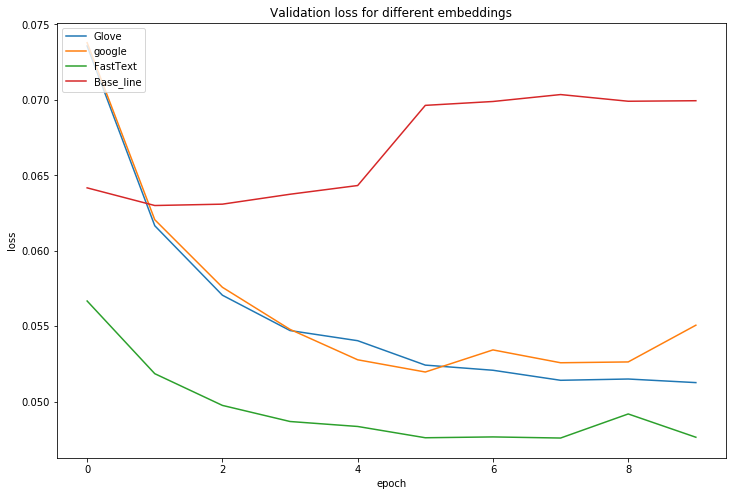

In [149]:
#f, ax = plt.subplots(1)
epochRange = np.arange(1,10,1)
plt.subplots(figsize = (12,8))
plt.plot(hist_glove.history['val_loss'])
plt.plot(hist_google.history['val_loss'])
plt.plot(hist_fasttext.history['val_loss'])
plt.plot(hist_base.history['val_loss'])
plt.title('Validation loss for different embeddings')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Glove', 'google','FastText', 'Base_line'], loc='upper left')
plt.show()

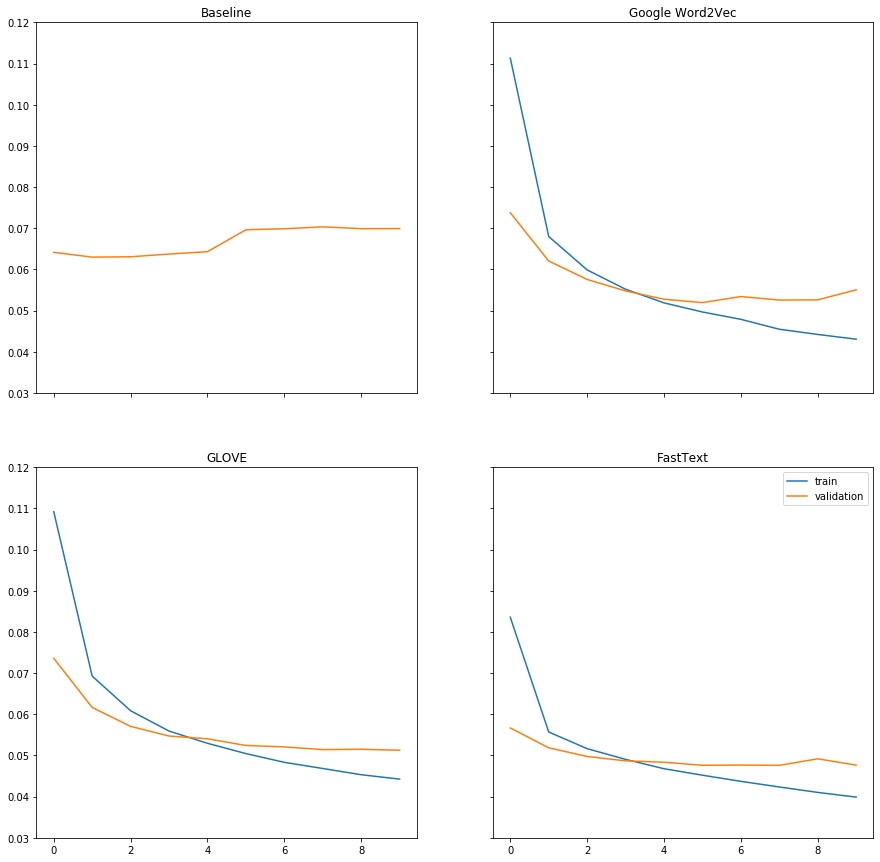

In [150]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row',figsize=(15,15))

plt.title('Training Vs Validation loss for all embeddings')
ax1.plot(hist_base.history['loss'])
ax1.plot(hist_base.history['val_loss'])
plt.legend(['train', 'validation'])
ax1.set_title('Baseline')
ax1.set_ylim(0.03, 0.12)

ax2.plot(hist_google.history['loss'])
ax2.plot(hist_google.history['val_loss'])
plt.legend(['train', 'validation'])
ax2.set_title('Google Word2Vec')
ax2.set_ylim(0.03, 0.12)

ax3.plot(hist_glove.history['loss'])
ax3.plot(hist_glove.history['val_loss'])
plt.legend(['train', 'validation'])
ax3.set_title('GLOVE')
ax3.set_ylim(0.03, 0.12)


ax4.plot(hist_fasttext.history['loss'])
ax4.plot(hist_fasttext.history['val_loss'])
plt.legend(['train', 'validation'])
ax4.set_title('FastText')
ax4.set_ylim(0.03, 0.12)

plt.show()